In [ ]:
# Это лучший скор, который удалось получить с помощью RandomForest
# Я пытался добавить новые фичи, такие как количество домов в районе и средняя
# цена квартиры в районе, но результат только снизился
# На корреляционной матрице есть два сильно коррелирующих признака Social_1 и Social_2.
# Я попытался удалить один из них, думал это улучшит модель, но скор снизился.
# Скор удалось повысить на моем наборе фич, используя LightGBM. Но это не попадало под условия задания,
# так что я остановился на таком варианте.

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = 'datasets/project_task/train.csv'
TEST_DATASET_PATH = 'datasets/project_task/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

**Тренировочный датасет**

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH).set_index('Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00000,47.98156,29.44275,6.00000,7,9.00000,1969,0.08904,B,B,33,7976,5,nan,0,11,B,184966.93073
15053,41,3.00000,65.68364,40.04954,8.00000,7,9.00000,1978,0.00007,B,B,46,10309,1,240.00000,1,16,B,300009.45006
4765,53,2.00000,44.94795,29.19761,0.00000,8,12.00000,1968,0.04964,B,B,34,7759,0,229.00000,1,3,B,220925.90852
5809,58,2.00000,53.35298,52.73151,9.00000,8,17.00000,1977,0.43789,B,B,23,5735,3,1084.00000,0,5,B,175616.22722
10783,99,1.00000,39.64919,23.77617,7.00000,11,12.00000,1976,0.01234,B,B,35,5776,1,2078.00000,2,4,B,150226.53164


In [6]:
print(train_df.info())
print(train_df.shape)
train_df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.00000,50.40080,43.58759,0.00000,20.00000,36.00000,75.00000,209.00000
Rooms,10000.00000,1.89050,0.83951,0.00000,1.00000,2.00000,2.00000,19.00000
Square,10000.00000,56.31578,21.05873,1.13686,41.77488,52.51331,65.90063,641.06519
LifeSquare,7887.00000,37.19964,86.24121,0.37062,22.76983,32.78126,45.12880,7480.59213
KitchenSquare,10000.00000,6.27330,28.56092,0.00000,1.00000,6.00000,9.00000,2014.00000
Floor,10000.00000,8.52670,5.24115,1.00000,4.00000,7.00000,12.00000,42.00000
HouseFloor,10000.00000,12.60940,6.77597,0.00000,9.00000,13.00000,17.00000,117.00000
HouseYear,10000.00000,3990.16630,200500.26143,1910.00000,1974.00000,1977.00000,2001.00000,20052011.00000
Ecology_1,10000.00000,0.11886,0.11903,0.00000,0.01765,0.07542,0.19578,0.52187
Social_1,10000.00000,24.68700,17.53261,0.00000,6.00000,25.00000,36.00000,74.00000


**Тестовый датасет**

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.00000,67.13391,50.80980,6.00000,5,9.00000,1973,0.00017,B,B,36,5992,0,nan,1,1,B
4996,4695,1,1.00000,40.19847,21.80706,10.00000,12,17.00000,2017,0.00712,B,B,1,264,0,nan,0,1,B
4997,5783,12,3.00000,77.84218,48.28263,9.00000,23,22.00000,1989,0.09080,B,B,74,19083,2,nan,5,15,B
4998,4780,62,2.00000,81.30522,nan,0.00000,4,0.00000,1977,0.07216,B,B,2,629,1,nan,0,0,A
4999,12504,30,2.00000,60.55569,nan,1.00000,10,17.00000,1977,0.00008,B,B,22,6398,141,1046.00000,3,23,B


In [8]:
print(test_df.info())
print(test_df.shape)
test_df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

,count,mean,std,min,25%,50%,75%,max
Id,5000.00000,8412.59540,4832.67404,1.00000,4221.75000,8320.50000,12598.25000,16795.00000
DistrictId,5000.00000,51.27920,44.17947,0.00000,21.00000,37.00000,77.00000,212.00000
Rooms,5000.00000,1.91000,0.83859,0.00000,1.00000,2.00000,2.00000,17.00000
Square,5000.00000,56.44950,19.09279,1.37854,41.90623,52.92134,66.28513,223.45369
LifeSquare,3959.00000,36.15881,17.82529,0.33349,23.09203,32.92509,45.17409,303.07109
KitchenSquare,5000.00000,5.97680,9.95002,0.00000,1.00000,6.00000,9.00000,620.00000
Floor,5000.00000,8.63200,5.48323,1.00000,4.00000,7.00000,12.00000,78.00000
HouseFloor,5000.00000,12.60100,6.78921,0.00000,9.00000,12.00000,17.00000,99.00000
HouseYear,5000.00000,1984.39260,18.57315,1908.00000,1973.00000,1977.00000,2000.00000,2020.00000
Ecology_1,5000.00000,0.11987,0.12007,0.00000,0.01951,0.07216,0.19578,0.52187


### Приведение типов

In [9]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

### Обзор данных

In [10]:
# Посмотрим информацию по датафрейму
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [11]:
# Видим пропуски в двух фичах. 'Healthcare_1' удалим, т.к. пропусков 48%,
train_df = train_df.drop('Healthcare_1', axis = 1)
test_df = test_df.drop('Healthcare_1', axis = 1)

In [12]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.00000,1.89050,0.83951,0.00000,1.00000,2.00000,2.00000,19.00000
Square,10000.00000,56.31578,21.05873,1.13686,41.77488,52.51331,65.90063,641.06519
LifeSquare,7887.00000,37.19964,86.24121,0.37062,22.76983,32.78126,45.12880,7480.59213
KitchenSquare,10000.00000,6.27330,28.56092,0.00000,1.00000,6.00000,9.00000,2014.00000
Floor,10000.00000,8.52670,5.24115,1.00000,4.00000,7.00000,12.00000,42.00000
HouseFloor,10000.00000,12.60940,6.77597,0.00000,9.00000,13.00000,17.00000,117.00000
HouseYear,10000.00000,3990.16630,200500.26143,1910.00000,1974.00000,1977.00000,2001.00000,20052011.00000
Ecology_1,10000.00000,0.11886,0.11903,0.00000,0.01765,0.07542,0.19578,0.52187
Social_1,10000.00000,24.68700,17.53261,0.00000,6.00000,25.00000,36.00000,74.00000
Social_2,10000.00000,5352.15740,4006.79980,168.00000,1564.00000,5285.00000,7227.00000,19083.00000


In [13]:
train_df.describe(include=['O']).T

,count,unique,top,freq
DistrictId,10000,205,27,851
Ecology_2,10000,2,B,9903
Ecology_3,10000,2,B,9725
Shops_2,10000,2,B,9175


In [14]:
test_df.describe(include=['O']).T

,count,unique,top,freq
DistrictId,5000,201,27,391
Ecology_2,5000,2,B,4952
Ecology_3,5000,2,B,4851
Shops_2,5000,2,B,4588


In [15]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
for i in cat_colnames[1:]:
    print(str(train_df[i].value_counts()) + '\n' + '-'*30)


B    9903
A      97
Name: Ecology_2, dtype: int64
------------------------------
B    9725
A     275
Name: Ecology_3, dtype: int64
------------------------------
B    9175
A     825
Name: Shops_2, dtype: int64
------------------------------


### Посторим гистограммы, чтобы посмотреть признаки с выбросами

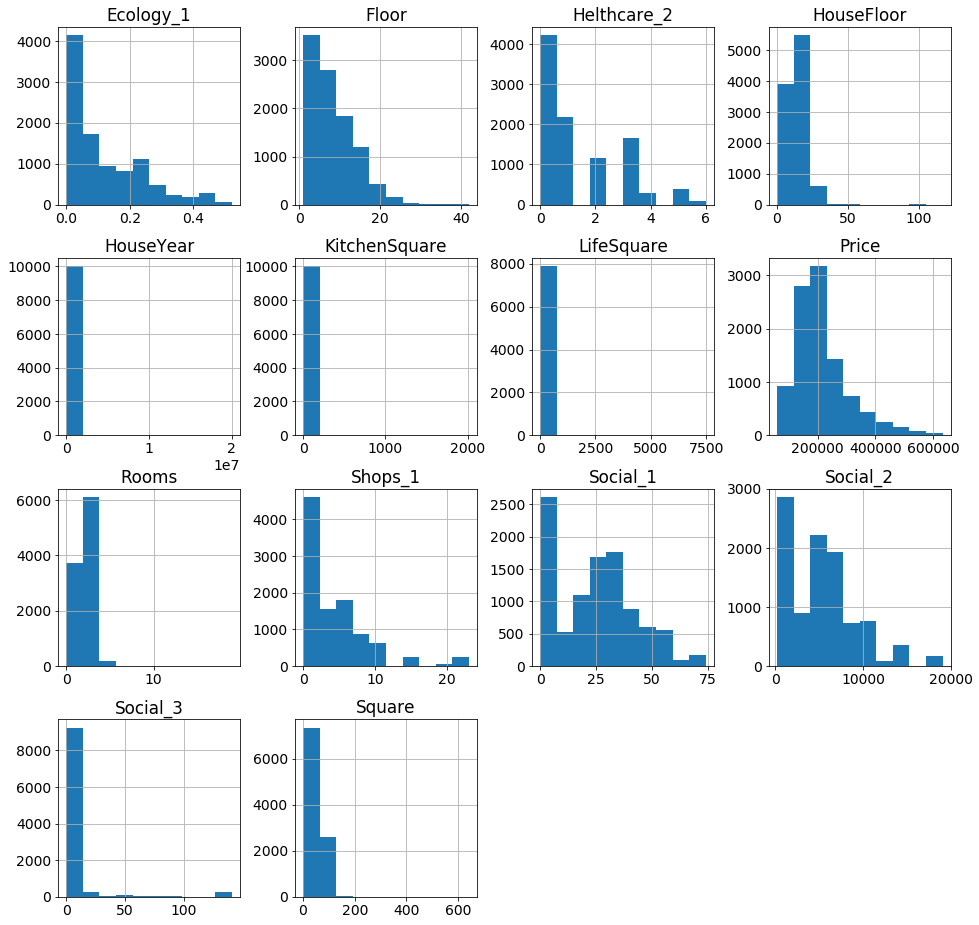

In [16]:
train_df.hist(
    figsize=(16,16)
)
plt.show()


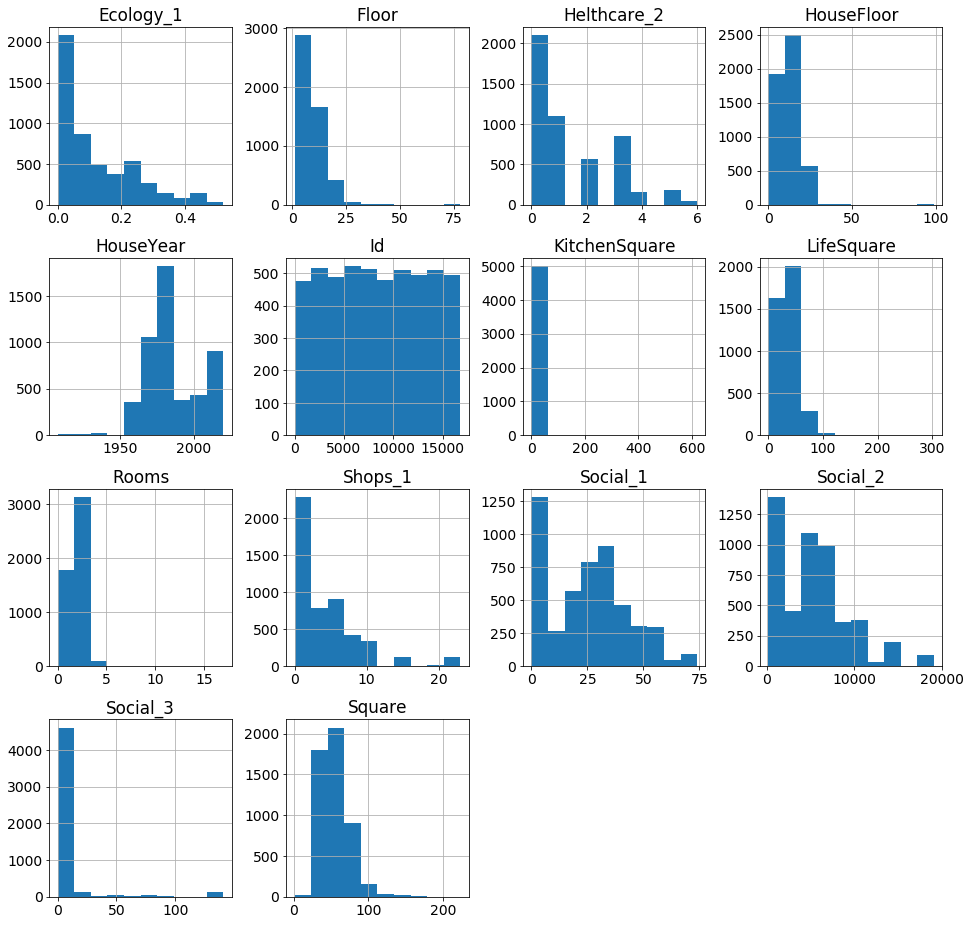

In [17]:
test_df.hist(
    figsize=(16,16)
)
plt.show()

In [18]:
# Видим, что 'KitchenSquare', 'LifeSquare' и  'HouseYear'(в тренировочном датасете) содержат выбросы. 
# Рассмотрим их подробнее

**признак HouseYear тренировочного датасета**

In [19]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [20]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

**признак Square тренировочного датасета**

In [21]:
train_df[['KitchenSquare', 'LifeSquare', 'Square']].describe()

,KitchenSquare,LifeSquare,Square
count,10000.00000,7887.00000,10000.00000
mean,6.27330,37.19964,56.31578
std,28.56092,86.24121,21.05873
min,0.00000,0.37062,1.13686
25%,1.00000,22.76983,41.77488
50%,6.00000,32.78126,52.51331
75%,9.00000,45.12880,65.90063
max,2014.00000,7480.59213,641.06519


In [22]:
# Чтобы заменить выбросы в Square сделаем следующее
# Посчитаем первый и третий квартили
first_quartile = train_df['Square'].describe()['25%']
third_quartile = train_df['Square'].describe()['75%']
# Вычислим межквартильный интервал
iqr = third_quartile - first_quartile

In [23]:
# Заменим значения которые превышают 3 межквартильных размаха на медианные
train_df.loc[(train_df['Square'] < (first_quartile - 3 * iqr)) |
            (train_df['Square'] > (third_quartile + 3 * iqr)), 'Square'] = train_df['Square'].median()

In [24]:
train_df['Square'].describe()

count   10000.00000
mean       55.79542
std        17.99888
min         1.13686
25%        41.77488
50%        52.51304
75%        65.77685
max       137.90778
Name: Square, dtype: float64

In [25]:
# минимальная площадь все равно выглядит неправдоподобно, зададим минимальную площадь равную 10
train_df.loc[train_df['Square'] < 10, 'Square'] = 10

In [26]:
train_df['Square'].describe()

count   10000.00000
mean       55.80298
std        17.97825
min        10.00000
25%        41.77488
50%        52.51304
75%        65.77685
max       137.90778
Name: Square, dtype: float64

**Square тестового датасета**

In [27]:
test_df['Square'].describe()

count   5000.00000
mean      56.44950
std       19.09279
min        1.37854
25%       41.90623
50%       52.92134
75%       66.28513
max      223.45369
Name: Square, dtype: float64

In [28]:
# С выбросами все нормально. Заменим только минимальную площадь
test_df.loc[test_df['Square'] < 10, 'Square'] = 10

In [29]:
test_df['Square'].describe()

count   5000.00000
mean      56.46010
std       19.06503
min       10.00000
25%       41.90623
50%       52.92134
75%       66.28513
max      223.45369
Name: Square, dtype: float64

**признак LifeSquare тренировочного датасета**

In [30]:
# У нас много строк, где жилая площадь больше общей, чего быть не может
# Чтобы заполнить пропуски и выбросы в LifeSquare, посмотрим как в средней этот параметр относится к общей
# жилой площади в тех случаях, где общая площадь больше чем жилая
_ = train_df[train_df['Square'] > train_df['LifeSquare']][['Square', 'LifeSquare']].median()
life_to_sq = _[1] / _[0]
life_to_sq

0.6355940680921265

In [31]:
# Получаем что в среднем жилая площадь составляет 63% от общей площади. Выглядит правдоподобно
# Заменим все пропуски и выбросы с учетом этого коэффициента
train_df.loc[train_df['Square'] < train_df['LifeSquare'], 'LifeSquare']= train_df['Square'] * life_to_sq
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare']= train_df['Square'] * life_to_sq
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare']= train_df['Square'] * life_to_sq

In [32]:
train_df['LifeSquare'].describe()

count   10000.00000
mean       35.80561
std        14.00435
min         6.35594
25%        24.94390
50%        33.16875
75%        43.85929
max       136.69719
Name: LifeSquare, dtype: float64

**признак LifeSquare тестового датасета**

In [33]:
test_df['LifeSquare'].describe()

count   3959.00000
mean      36.15881
std       17.82529
min        0.33349
25%       23.09203
50%       32.92509
75%       45.17409
max      303.07109
Name: LifeSquare, dtype: float64

In [34]:
#Коэффициент будем использовать тот, что рассчитали на трейне
test_df.loc[test_df['Square'] < test_df['LifeSquare'], 'LifeSquare']= test_df['Square'] * life_to_sq
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare']= test_df['Square'] * life_to_sq
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare']= test_df['Square'] * life_to_sq

In [35]:
test_df['LifeSquare'].describe()

count   5000.00000
mean      36.23410
std       14.36575
min        6.35594
25%       25.04885
50%       33.53277
75%       44.39945
max      136.92109
Name: LifeSquare, dtype: float64

**признак KitchenSquare тренировочного датасета**

In [36]:
#  Cделаем для площади кухни также как и для LifeSquare
_ = train_df[train_df['Square'] > train_df['KitchenSquare']][['Square', 'KitchenSquare']].median()
life_to_sq = _[1] / _[0]
life_to_sq

0.11425674764515831

In [37]:
train_df.loc[train_df['Square'] < train_df['KitchenSquare'], 'KitchenSquare'] = train_df['Square'] * life_to_sq
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = train_df['Square'] * life_to_sq

**признак KitchenSquare тестового датасета**

In [38]:
test_df.loc[test_df['Square'] < test_df['KitchenSquare'], 'KitchenSquare'] = test_df['Square'] * life_to_sq
test_df.loc[test_df['KitchenSquare'] < 5, 'KitchenSquare'] = test_df['Square'] * life_to_sq

In [39]:
train_df[['KitchenSquare', 'LifeSquare', 'Square']].describe()

,KitchenSquare,LifeSquare,Square
count,10000.00000,10000.00000,10000.00000
mean,7.76570,35.80561,55.80298
std,3.94819,14.00435,17.97825
min,1.14257,6.35594,10.00000
25%,5.93929,24.94390,41.77488
50%,7.48700,33.16875,52.51304
75%,9.00000,43.85929,65.77685
max,123.00000,136.69719,137.90778


**HouseFloor, Floor, Rooms**

In [40]:
# Заменим этажность дома 0 на медианное значение(для теста оставим медиану из трейна)
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

# Если этаж квартиры больше этажа дома, то приравняем этаж квартиры и этаж дома
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor']
test_df.loc[test_df['Floor'] > test_df['HouseFloor'], 'Floor'] = test_df['HouseFloor']

In [41]:
train_df['Rooms'].value_counts()

2.00000     3880
1.00000     3705
3.00000     2235
4.00000      150
5.00000       18
0.00000        8
10.00000       2
19.00000       1
6.00000        1
Name: Rooms, dtype: int64

In [42]:
train_df['Rooms'].describe()

count   10000.00000
mean        1.89050
std         0.83951
min         0.00000
25%         1.00000
50%         2.00000
75%         2.00000
max        19.00000
Name: Rooms, dtype: float64

In [43]:
train_df.loc[train_df['Rooms'] < 1, 'Rooms'] = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'] > 10, 'Rooms'] = train_df['Rooms'].median()
# для теста оставим медиану трейна
test_df.loc[test_df['Rooms'] < 1, 'Rooms'] = train_df['Rooms'].median()
test_df.loc[test_df['Rooms'] > 10, 'Rooms'] = train_df['Rooms'].median()

### Dummy переменные

In [44]:
# трейн дс
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})
# тестовый дс
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [45]:
train_df.tail()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
Id,,,,,,,,,,,,,,,,,,,,,
77,32,2.00000,50.40178,30.47620,5.00000,5.00000,5.00000,1968,0.13565,B,B,46,7960,6,3,11,B,196684.31604,1,1,1
6159,18,1.00000,41.52155,20.53922,9.00000,13.00000,13.00000,2000,0.00000,B,B,30,5562,0,0,5,A,189050.28957,1,1,0
5123,27,1.00000,47.93901,30.46975,5.47736,12.00000,16.00000,2015,0.07216,B,B,2,629,1,0,0,A,159143.80537,1,1,0
5400,75,2.00000,43.60256,33.84015,8.00000,1.00000,5.00000,1961,0.30747,B,A,30,5048,9,2,5,B,181595.33981,1,0,1
6306,128,1.00000,38.66664,21.15787,8.00000,7.00000,17.00000,1990,0.00000,B,B,27,4798,0,2,8,B,218714.07762,1,1,1


In [46]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
4995,8180,11,3.00000,67.13391,50.80980,6.00000,5.00000,9.00000,1973,0.00017,B,B,36,5992,0,1,1,B,1,1,1
4996,4695,1,1.00000,40.19847,21.80706,10.00000,12.00000,17.00000,2017,0.00712,B,B,1,264,0,0,1,B,1,1,1
4997,5783,12,3.00000,77.84218,48.28263,9.00000,22.00000,22.00000,1989,0.09080,B,B,74,19083,2,5,15,B,1,1,1
4998,4780,62,2.00000,81.30522,51.67712,9.28967,4.00000,13.00000,1977,0.07216,B,B,2,629,1,0,0,A,1,1,0
4999,12504,30,2.00000,60.55569,38.48884,6.91890,10.00000,17.00000,1977,0.00008,B,B,22,6398,141,3,23,B,1,1,1


In [47]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin']

In [48]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin','Social_1','Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
target_name = 'Price'

In [49]:
X = train_df[feature_names]
y = train_df[target_name]

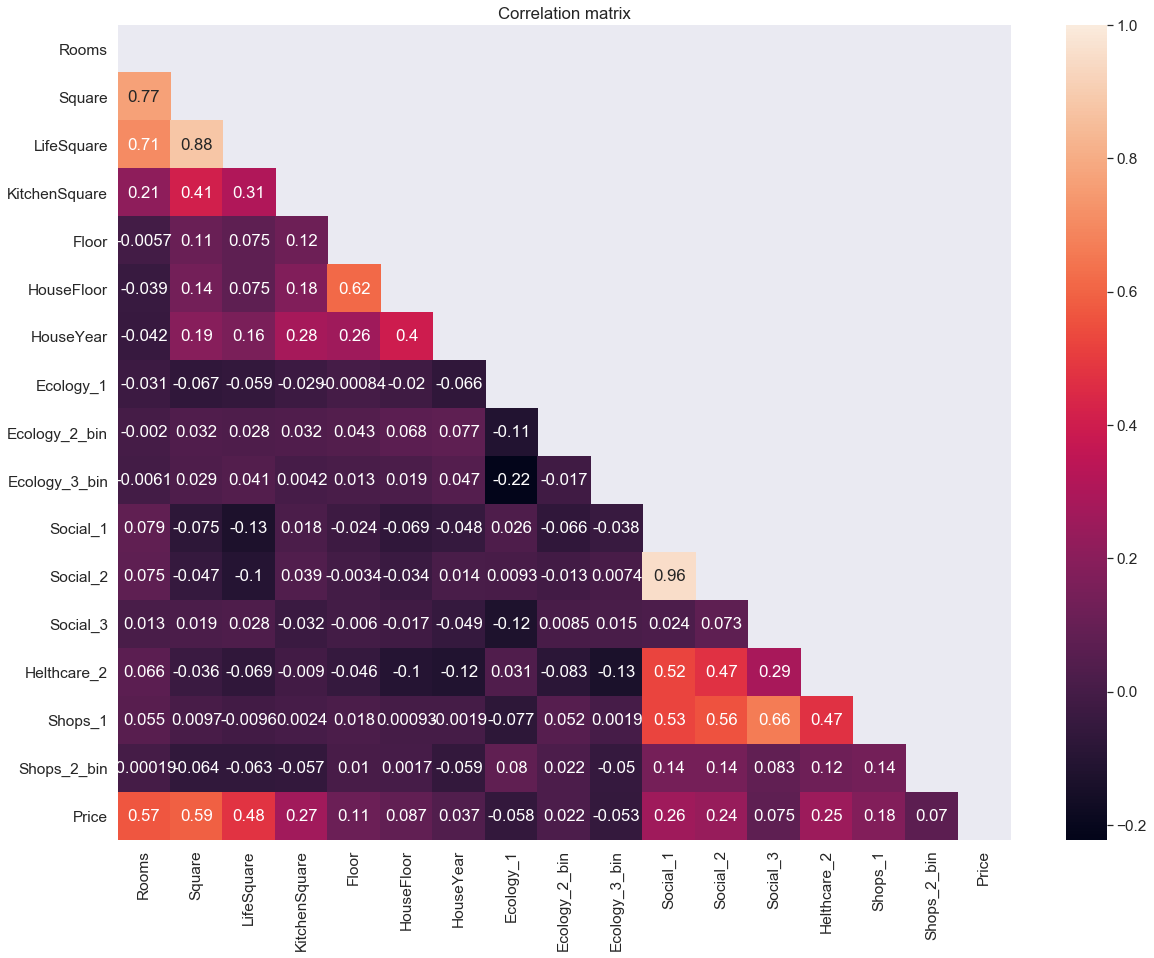

In [50]:
plt.figure(figsize = (20,15))

corr = train_df[feature_names + list(target_name.split(' '))].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.set(font_scale=1.4)
sns.heatmap(
    data=corr,
    mask=mask,
    annot=True
)

plt.title('Correlation matrix')
plt.show()

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [52]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2_bin
Id,,,,,,,,,,,,,,,,
6225,1.00000,39.83774,23.28137,7.00000,13.00000,17.00000,2010,0.00766,1,1,35,7077,56,3,19,1
12927,2.00000,17.41418,11.06835,1.98969,4.00000,20.00000,1977,0.07216,1,1,2,629,1,0,0,0
13125,1.00000,44.84656,21.58987,8.00000,3.00000,14.00000,2004,0.00000,1,1,36,6714,2,0,2,1
12282,2.00000,52.44986,27.14581,7.00000,3.00000,5.00000,1953,0.16909,1,1,19,3856,10,2,5,1
1214,3.00000,65.52154,39.97374,8.00000,5.00000,9.00000,1976,0.16909,1,1,19,3856,10,2,5,1


In [53]:
X_train.shape

(7000, 16)

In [54]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [55]:
y_pred_train = rf_model.predict(X=X_val)

r2_score(
    y_true=y_val,
    y_pred=y_pred_train
)

0.7165670841082692

In [56]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.73996306, 0.69474933, 0.724468  , 0.72688121, 0.71478969])

In [57]:
cv_score.mean()

0.7201702578501996

**Важность признаков**

In [58]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.39008
10,Social_1,0.10404
11,Social_2,0.09178
0,Rooms,0.08686
12,Social_3,0.06131
7,Ecology_1,0.05285
6,HouseYear,0.04677
2,LifeSquare,0.04055
3,KitchenSquare,0.03301
5,HouseFloor,0.02791


### Предсказание на тестовом датасете

In [59]:
y_pred_test = rf_model.predict(
    X=test_df[feature_names]
)

In [60]:
test_df[feature_names]

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2_bin
0,2.00000,49.88264,33.43278,6.00000,6.00000,14.00000,1972,0.31020,1,1,11,2748,1,0,0,1
1,2.00000,69.26318,44.02327,7.91379,1.00000,1.00000,1977,0.07578,1,1,6,1437,3,0,2,1
2,1.00000,13.59782,8.64269,12.00000,2.00000,5.00000,1909,0.00000,1,1,30,7538,87,5,5,1
3,2.00000,73.04661,51.94084,9.00000,22.00000,22.00000,2007,0.10187,1,1,23,4583,3,3,3,1
4,1.00000,47.52711,43.38757,5.43029,17.00000,17.00000,2017,0.07216,1,1,2,629,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3.00000,67.13391,50.80980,6.00000,5.00000,9.00000,1973,0.00017,1,1,36,5992,0,1,1,1
4996,1.00000,40.19847,21.80706,10.00000,12.00000,17.00000,2017,0.00712,1,1,1,264,0,0,1,1
4997,3.00000,77.84218,48.28263,9.00000,22.00000,22.00000,1989,0.09080,1,1,74,19083,2,5,15,1
4998,2.00000,81.30522,51.67712,9.28967,4.00000,13.00000,1977,0.07216,1,1,2,629,1,0,0,0


In [61]:
test_df[target_name] = y_pred_test

In [62]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   float64
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
 18  Ecology_

In [63]:
test_df[['Id','Price']].to_csv('submission.csv', index=None)

In [64]:
test_df[['Id','Price']].shape

(5000, 2)

In [65]:
test_df[['Id','Price']]

,Id,Price
0,725,166336.60057
1,15856,182785.30162
2,5480,247351.68619
3,15664,342090.85550
4,14275,137667.10349
...,...,...
4995,8180,253315.27126
4996,4695,129751.48505
4997,5783,330056.68048
4998,4780,213443.26038
